In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Testing area

This is the area for us to test the performance of our swarm-optimized neural networks. The steps for testing a neural network are as follows:

1. Define a model using the Keras framework

2. Acquire some training and test data

3. Provide both model and data to a swarm and begin optimization

### Contents

- [How to use the swarm optimizer](#howto)
- [Testing on Iris dataset](#iris)
- [Testing on MNIST dataset](#mnist)

## How to use the swarm optimizer <a id="howto"></a>

In [2]:
from SwarmParty import NN_Swarm

#### Create a swarm

The first thing to do is create your own swarm, which can be created by making an instance of the swarm class. The is done as follows:

In [3]:
my_swarm = NN_Swarm()

This generates a swarm, with the parameters that can be defined at this point. These are *n\_particles*, *x\_min_*/*x\_max*, *v_min*/*v_max*, *c_1* and *c_2*. By default, these parameters are chosen to have some values, but they can be be easily changed like this:

In [4]:
my_swarm.n_particles = 50

#### Provide a network model

NN_Swarms are specifically designed from optimization of keras-defined neural network models. To do this, let's first create a super simple keras model:

In [5]:
# define the keras model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(10, input_dim=4, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='mse', optimizer="adam")

Once you have made a neural net, you can pass it to the swarm using the *provide_model()* method, as demonstrated:

In [6]:
my_swarm.provide_model(model)

*Note: The function described above also uses this model to infer the dimensionality of the data (from the number of weights and biases)*

#### Provide data

Now that it possesses a neural network model, the swarm works by using the model to evaluate the objective function for a given particles position at every iteration. The model needs to data to evaluate, so this is provided to the swarm next. Let's get some example data to pass to it first:

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
enc = OneHotEncoder(); scaler = StandardScaler();

iris = load_iris()
X = iris['data']; y = iris['target']
Y = enc.fit_transform(y[:, np.newaxis]).toarray()
X_scaled = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=2)

In [8]:
my_swarm.provide_data(X_train, X_test, Y_train, Y_test)

(50, 193)


#### Train the model using the swarm optimizer

The PSO algorithm can then be run, using the parameters previously set, with the simple function call my_swarm.train():

In [9]:
my_swarm.train(iterations=10)

#### Plot the training curve

You can do this using the inbuilt method "plot_training":

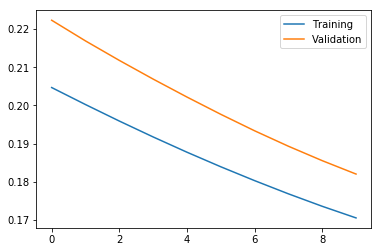

In [10]:
my_swarm.plot_training()

Alternatively, you can give the optional argument "get_curve" when you use my_swarm.train(), and this will give you back a numpy array containing a vector for the training data set, and a vector for the the validation data set.

### Summary

Once you have defined a model, and your training/test data, you implement the swarm optimizer with the following lines of code:

In [11]:
my_swarm2 = NN_Swarm()
my_swarm2.provide_model(model)
my_swarm2.provide_data(X_train, X_test, Y_train, Y_test)

(30, 193)


Then train by doing:

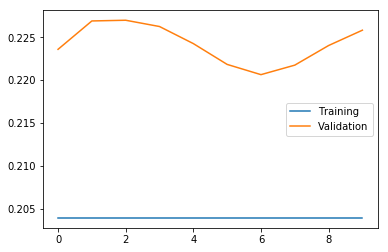

In [12]:
my_swarm2.train(iterations=10)
my_swarm2.plot_training()

## Test on the Iris data set <a id="iris"></a>

Although the data set above was actually also the Iris one, we'll do a more thorough, and commented version here. This is copied straight out of McKrimble's notebook (PSO_NN_for_Iris)

- [Definition of neural network and collection of dataset](#nniris)
- [Experimental region](#irisexp)
    * [Test 1: Default Parameters](#irisdefault)
    * [Test 2: Altering Vmax](#irisvmax)

### Definition of neural network and collection of dataset <a id="nniris"></a>

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

from IPython.display import SVG
from keras.utils import model_to_dot
import pydot

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

2.0.0


Using TensorFlow backend.


In [14]:
iris = load_iris()
X = iris['data'] # array of samples 4 dimensions each describing a feature
y = iris['target'] # array of labels (0, 1, 2)
names = iris['target_names'] # array of labels (0, 1, 2)
feature_names = iris['feature_names'] # ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray() # Y is output of 3 dimensions now, one hot encoding

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
Iris_Xtrain, Iris_Xtest, Iris_Ytrain, Iris_Ytest = train_test_split(X_scaled, Y, test_size=0.2, random_state=2)
print("Iris_Xtrain shape = {}".format(Iris_Xtrain.shape))
print("Iris_Ytrain shape = {}".format(Iris_Ytrain.shape))
print("Iris_Xtest shape = {}".format(Iris_Xtest.shape))
print("Iris_Ytest shape = {}".format(Iris_Ytest.shape))

n_features = X.shape[1]
n_classes = Y.shape[1]

Iris_Xtrain shape = (120, 4)
Iris_Ytrain shape = (120, 3)
Iris_Xtest shape = (30, 4)
Iris_Ytest shape = (30, 3)


In [15]:
def build_model():
    model = keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer)
    return model

irismodel = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

irismodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


### Experimental region <a id="irisexp"></a>

This is where we can run our experiments and invesigate parameters etc.

#### Test 1 - Default Parameters <a id="irisdefault"></a>

In [38]:
iris_swarm1 = NN_Swarm(v_max=0.1)
iris_swarm1.provide_model(irismodel)
iris_swarm1.provide_data(Iris_Xtrain, Iris_Xtest, Iris_Ytrain, Iris_Ytest)

(30, 193)


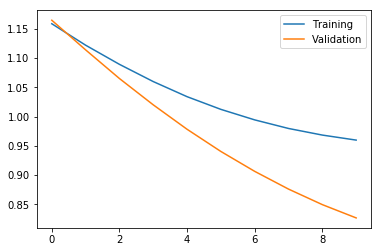

In [39]:
iris_swarm1.train(iterations=10)
iris_swarm1.plot_training()

#### Test 2 - Altering Vmax <a id="irisvmax"></a>

In [20]:
iris_swarm2 = NN_Swarm(v_max=0.5)
iris_swarm2.provide_model(irismodel)
iris_swarm2.provide_data(Iris_Xtrain, Iris_Xtest, Iris_Ytrain, Iris_Ytest)

(30, 193)


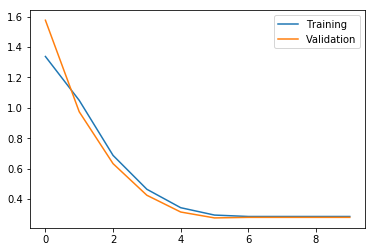

In [21]:
iris_swarm2.train(iterations=10)
iris_swarm2.plot_training()

From this simple experiment, it seems that increasing vmax will result in an increased initial learning rate (note that the above experiment only ran for 10 iterations). Let's see what happens with a very large v_max:

In [22]:
iris_swarm3 = NN_Swarm(v_max=5)
iris_swarm3.provide_model(irismodel)
iris_swarm3.provide_data(Iris_Xtrain, Iris_Xtest, Iris_Ytrain, Iris_Ytest)

(30, 193)


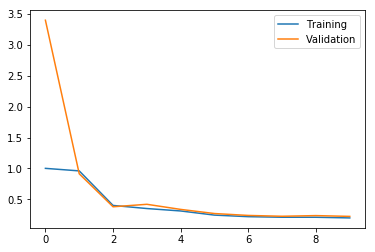

In [23]:
iris_swarm3.train(iterations=10)
iris_swarm3.plot_training()

This actually led to even better training results! Let's now effectively remove vmax from the algorithm:

In [24]:
iris_swarm4 = NN_Swarm(v_max=20)
iris_swarm4.provide_model(irismodel)
iris_swarm4.provide_data(Iris_Xtrain, Iris_Xtest, Iris_Ytrain, Iris_Ytest)

(30, 193)


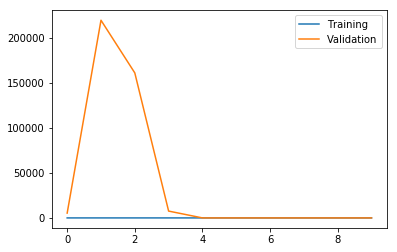

In [25]:
iris_swarm4.train(iterations=10)
iris_swarm4.plot_training()

## Test on the MNIST data set <a id="mnist"></a>

Although the data set above was actually also the Iris one, we'll do a more thorough, and commented version here. This is copied straight out of McKrimble's notebook (PSO_NN_for_Iris)

- [Definition of neural network and collection of dataset](#nnmnist)
- [Experimental region](#mnistexp)
    * [Test 1: Default Parameters](#mnistdefault)
    * [Test 2: Altering Vmax](#mnistvmax)

### Definition of neural network and collection of dataset <a id="nnmnist"></a>

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

from IPython.display import SVG
from keras.utils import model_to_dot
import pydot

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

2.0.0


In [27]:
# The digits dataset
digits = load_digits()
X = digits['data'] # (1797, 64), 1797 digits, 64 pixels per 8x8 image
y = digits['target'] # 1797 labels of 0-9
images = digits['images'] # (1797, 8, 8) dataset
names = digits['target_names'] # [0 1 2 3 4 5 6 7 8 9]

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

#preprocess: scale between 0 and 1
X /= 16.0
images /= 16.0

In [28]:
# Split the data set into training and testing
XtrainMNIST, XtestMNIST, YtrainMNIST, YtestMNIST = train_test_split(images, y, test_size=0.2, random_state=2)
print("XtrainMNIST shape = {}".format(XtrainMNIST.shape))
print("YtrainMNIST shape = {}".format(YtrainMNIST.shape))
print("XtestMNIST shape = {}".format(XtestMNIST.shape))
print("YtestMNIST shape = {}".format(YtestMNIST.shape))

XtrainMNIST shape = (1437, 8, 8)
YtrainMNIST shape = (1437,)
XtestMNIST shape = (360, 8, 8)
YtestMNIST shape = (360,)


In [29]:
def build_model():
    
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(8, 8)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    return model

mnistmodel = build_model()
mnistmodel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 9,610
Trainable params: 9,610
Non-trainable params: 0
_________________________________________________________________


### Experimental region <a id="mnistexp"></a>

Weirdly, it appears that keras is just as fast at evaluating the output of the entire (larger) dataset for MNIST as it is for the same dataset in iris. I really have no clue why this is, but we give thanks to the TensorFlow gods for such a phenomenom

In [30]:
%timeit mnistmodel.evaluate(XtrainMNIST, YtrainMNIST, verbose=0)

57.4 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Standard values <a id="mnistdefault"></a>

*Note: I've just realised that v_max = 1 isn't actually the standard value of 0.1 that we used. From playing around though, any smaller and things just get boring*

In [31]:
mnist_swarm1 = NN_Swarm(v_max=1)
mnist_swarm1.provide_model(mnistmodel)
mnist_swarm1.provide_data(XtrainMNIST, XtestMNIST, YtrainMNIST, YtestMNIST)

(30, 9610)


In [32]:
mnist_swarm1.train(iterations = 40)

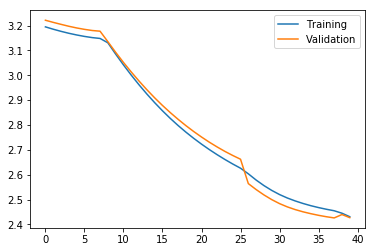

In [33]:
mnist_swarm1.plot_training()

#### Altering v_max <a id="mnistvmax"></a>

The dimensionality of this data is a lot greater than it was for the Iris dataset:

In [34]:
print("Number of dimensions for MNIST = %d" % mnist_swarm1.n_dims)

Number of dimensions for MNIST = 9610


This suggests we might be able to use a slightly speedier learning rate. Let's try this out:

In [35]:
mnist_swarm2 = NN_Swarm(v_max=10)
mnist_swarm2.provide_model(mnistmodel)
mnist_swarm2.provide_data(XtrainMNIST, XtestMNIST, YtrainMNIST, YtestMNIST)

(30, 9610)


In [36]:
mnist_swarm2.train(iterations = 20)

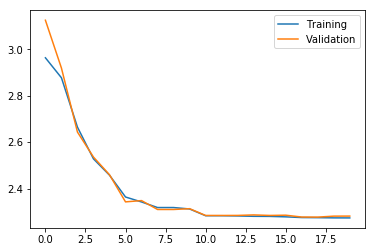

In [37]:
mnist_swarm2.plot_training()